In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [62]:
def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x.shape[1])
    if steps==1: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps-1):
        #print(str(n+1)+'/'+str(steps-1),end='\r')
        print('Iteration: '+str(n+1))
        print()
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
        print('=========')
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    print('fwd pass')
    print('Initial rho: '+str(rho_[0,0]))
    print('Initial cdf: '+str(Fm(rho_[0,0])))
    #print('pseudorandom: '+str(pseudo_random(x_,u_)[0,0]))
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    print('Final cdf: '+str(Fm(rho_[0,0])))
    print('Final rho: '+str(rho_[0,0]))
    print()
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    print('bwd pass')
    print('Final rho: '+str(rho_[0,0]))
    print('Final cdf: '+str(Fm(rho_[0,0])))
    #print('pseudorandom: '+str(pseudo_random(x_,u_)[0,0]))
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    print('Initial cdf: '+str(Fm(rho_[0,0])))
    print('Initial rho: '+str(rho_[0,0]))
    print()
    lJ=lJ+lm(rho_)
    u_=(u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    print('Hamiltonian dynamics')
    print('Initial x: '+str(x[0,0]))
    print('Initial rho: '+str(rho[0,0]))
    rho_ = rho_  + epsilon*grad_lp(x_)/2
    for l in range(L):
        x_    = x_   - epsilon*grad_lm(rho_)
        if l<L-1: rho_  = rho_ + epsilon*grad_lp(x_)
    # end for
    rho_ = rho_  + epsilon*grad_lp(x_)/2
    print('Final x: '+str(x_[0,0]))
    print('Final rho: '+str(rho_[0,0]))
    print()
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))#(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,z): return 0.5*np.sin(2*x+u)+0.5

In [63]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=100
sigma0=0.3
def lq0(x): return gauss_lp(x,mu0,sigma0)
def randq0(size): return mu0+sigma0*np.random.randn(1,size)

ss=1000
q0_sample=randq0(ss)

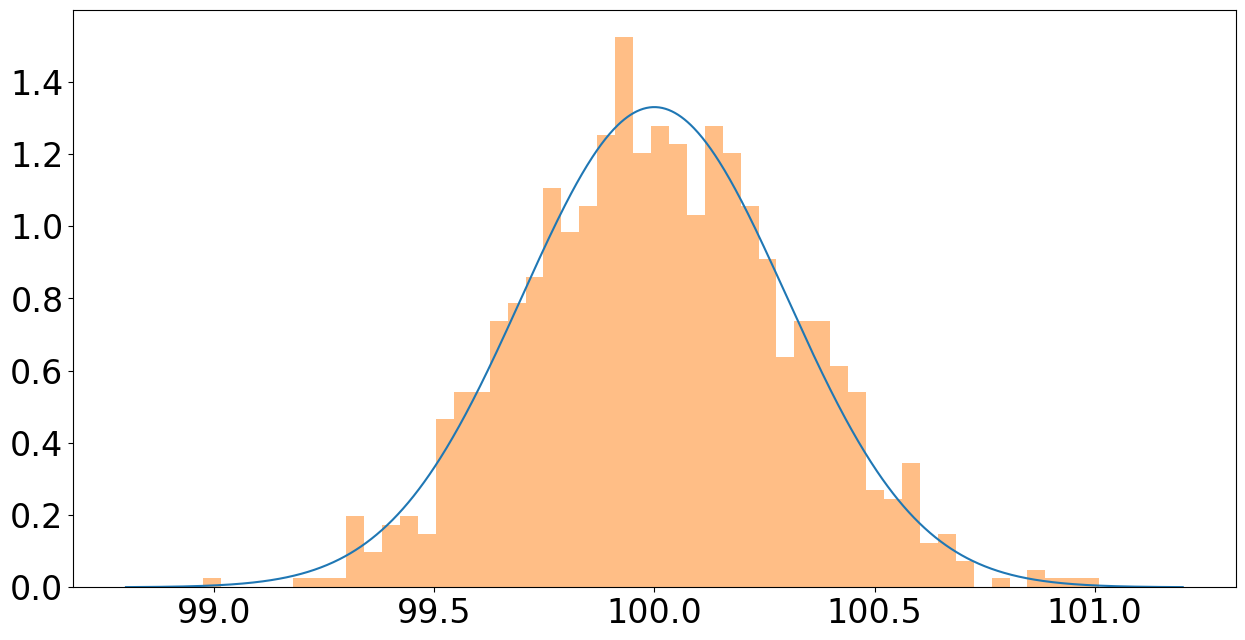

In [64]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(q0_sample[0,:],alpha=0.5,density=True,bins=50);

## Forward pass

In [65]:
# settings
steps=100
x=q0_sample
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16
direction='fwd'

In [66]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction)

Iteration: 1

Hamiltonian dynamics
Initial x: 99.64807698958153
Initial rho: 0.2624035141431849
Final x: 94.64807698958181
Final rho: -485.4779814337652

fwd pass
Initial rho: -485.4779814337652
Initial cdf: 0.0
Final cdf: 0.9684057744986785
Final rho: 2.761633731827772

Iteration: 2

Hamiltonian dynamics
Initial x: 94.64807698958181
Initial rho: 2.761633731827772
Final x: 89.6480769895821
Final rho: -457.978751216082

fwd pass
Initial rho: -457.978751216082
Initial cdf: 0.0
Final cdf: 0.20213270555737944
Final rho: -0.9056836585187131

Iteration: 3

Hamiltonian dynamics
Initial x: 89.6480769895821
Initial rho: -0.9056836585187131
Final x: 84.64807698958238
Final rho: -436.6460686064299

fwd pass
Initial rho: -436.6460686064299
Initial cdf: 0.0
Final cdf: 0.5314581579211768
Final rho: 0.06498268999780009

Iteration: 4

Hamiltonian dynamics
Initial x: 84.64807698958238
Initial rho: 0.06498268999780009
Final x: 79.64807698958266
Final rho: -410.67540225791475

fwd pass
Initial rho: -410.

In [67]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

Iteration: 1

bwd pass
Final rho: -2.6153844802674393
Final cdf: 0.036569831266170194
Initial cdf: 0.8552388386693062
Initial rho: 1.2395228773030835

Hamiltonian dynamics
Initial x: -0.5519230104170926
Initial rho: 1.2395228773030835
Final x: 1.0480769895829074
Final rho: 0.829907825217621

Iteration: 2

bwd pass
Final rho: 0.829907825217621
Final cdf: 0.7819552595389777
Initial cdf: 0.9863207551987515
Initial rho: 3.598728392338715

Hamiltonian dynamics
Initial x: 1.0480769895829074
Initial rho: 3.598728392338715
Final x: -1.751923010417093
Final rho: -2.4508866597467494

Iteration: 3

bwd pass
Final rho: -2.4508866597467494
Final cdf: 0.0431085536801582
Initial cdf: 0.5683747114098219
Initial rho: 0.1470502740990457

Hamiltonian dynamics
Initial x: -1.751923010417093
Initial rho: 0.1470502740990457
Final x: 0.6480769895829075
Final rho: 1.457435222013583

Iteration: 4

bwd pass
Final rho: 1.457435222013583
Final cdf: 0.8835836631483089
Initial cdf: 0.8883484586249666
Initial rho: 1.

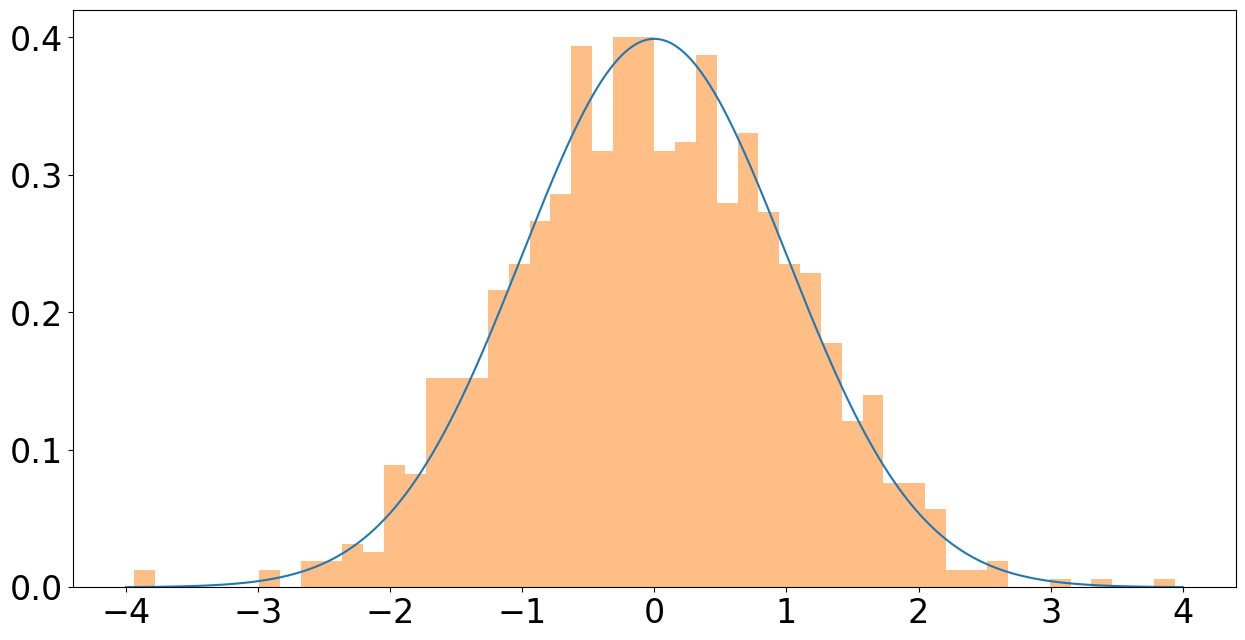

In [68]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])))
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50);

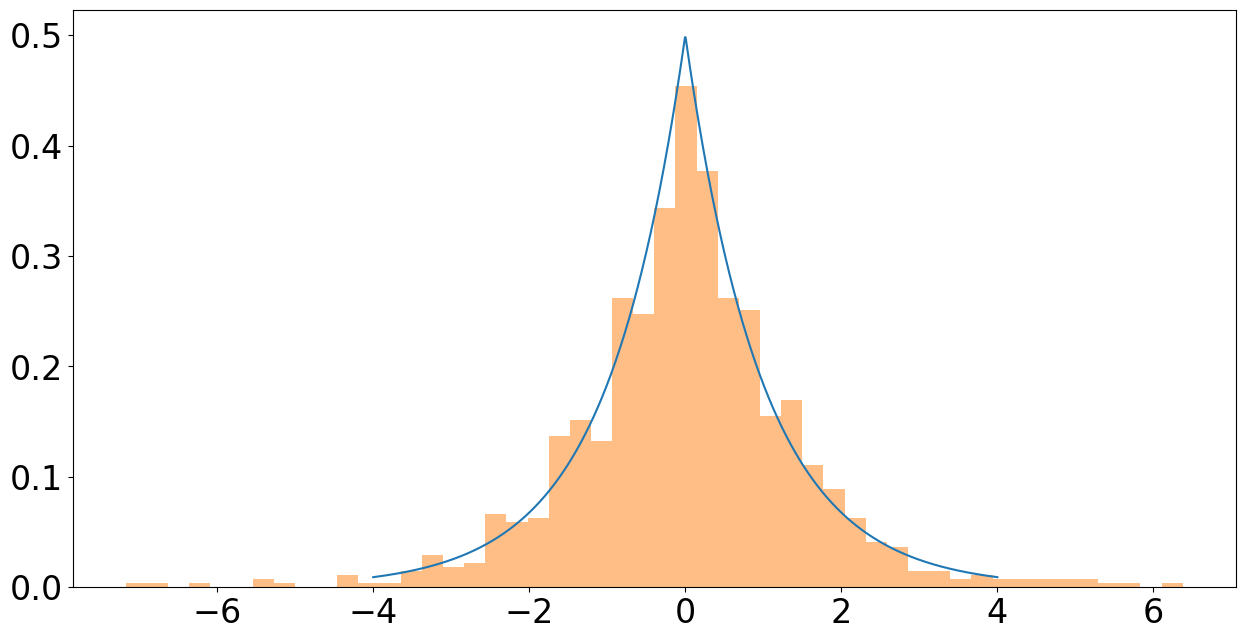

In [69]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50);

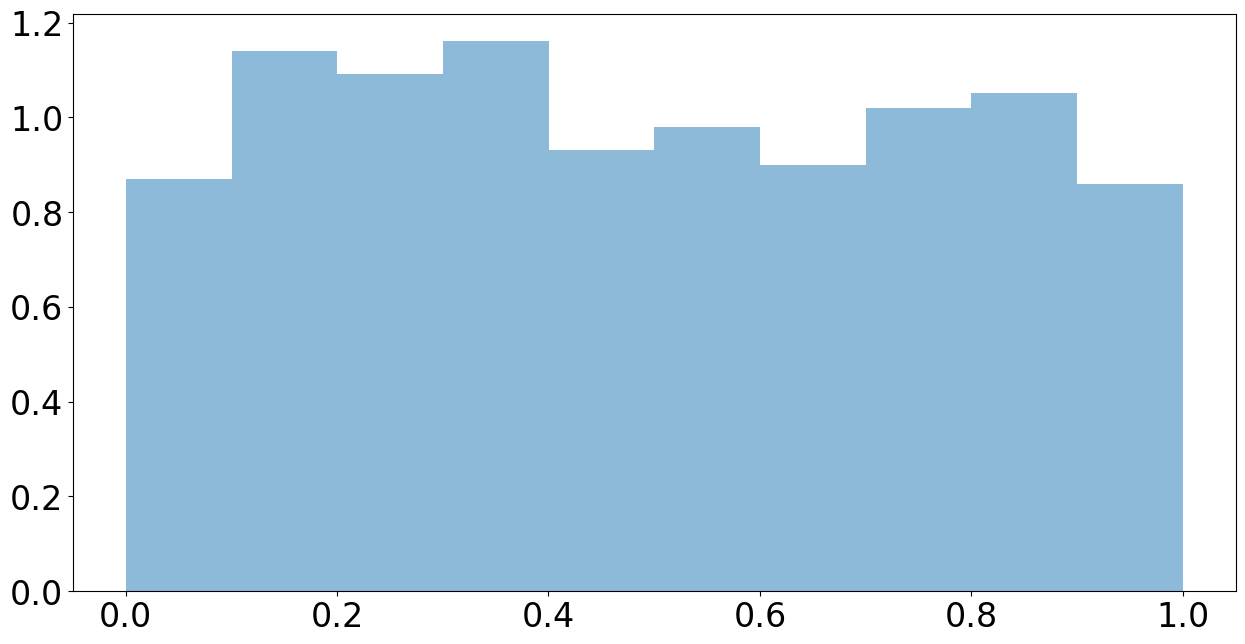

In [70]:
plt.hist(up,alpha=0.5,density=True,bins=10);

## Backward pass

In [71]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

Iteration: 1

bwd pass
Final rho: -2.6153844802674393
Final cdf: 0.036569831266170194
Initial cdf: 0.8552388386693062
Initial rho: 1.2395228773030835

Hamiltonian dynamics
Initial x: -0.5519230104170926
Initial rho: 1.2395228773030835
Final x: 1.0480769895829074
Final rho: 0.829907825217621

Iteration: 2

bwd pass
Final rho: 0.829907825217621
Final cdf: 0.7819552595389777
Initial cdf: 0.9863207551987515
Initial rho: 3.598728392338715

Hamiltonian dynamics
Initial x: 1.0480769895829074
Initial rho: 3.598728392338715
Final x: -1.751923010417093
Final rho: -2.4508866597467494

Iteration: 3

bwd pass
Final rho: -2.4508866597467494
Final cdf: 0.0431085536801582
Initial cdf: 0.5683747114098219
Initial rho: 0.1470502740990457

Hamiltonian dynamics
Initial x: -1.751923010417093
Initial rho: 0.1470502740990457
Final x: 0.6480769895829075
Final rho: 1.457435222013583

Iteration: 4

bwd pass
Final rho: 1.457435222013583
Final cdf: 0.8835836631483089
Initial cdf: 0.8883484586249666
Initial rho: 1.

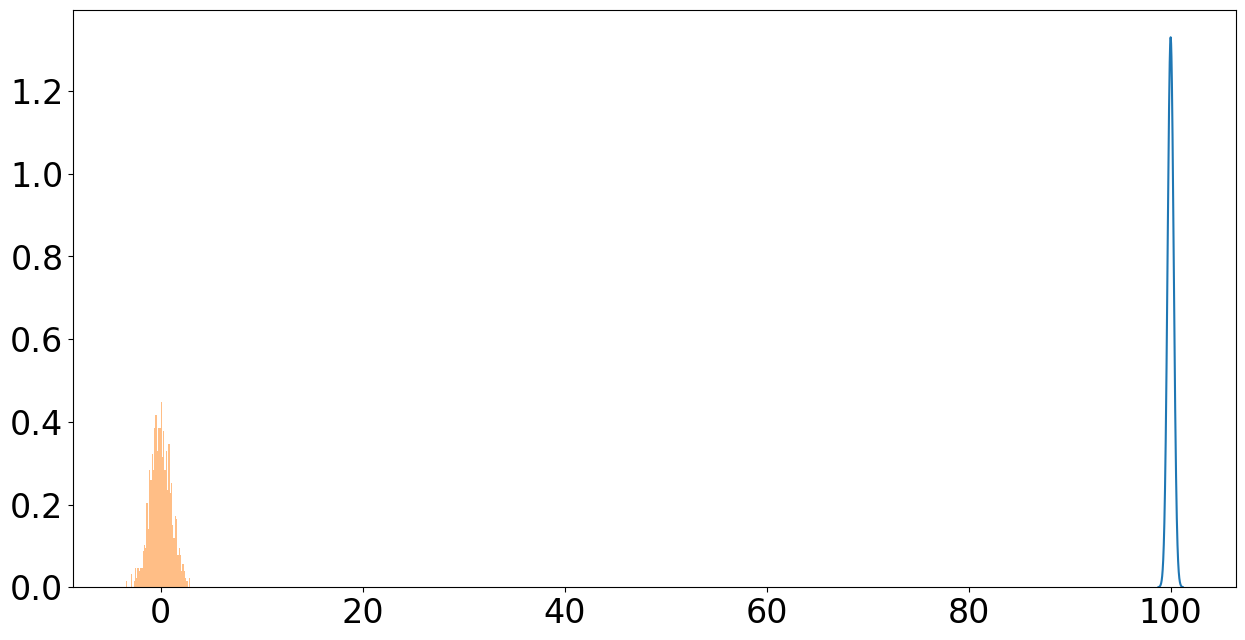

In [72]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50);

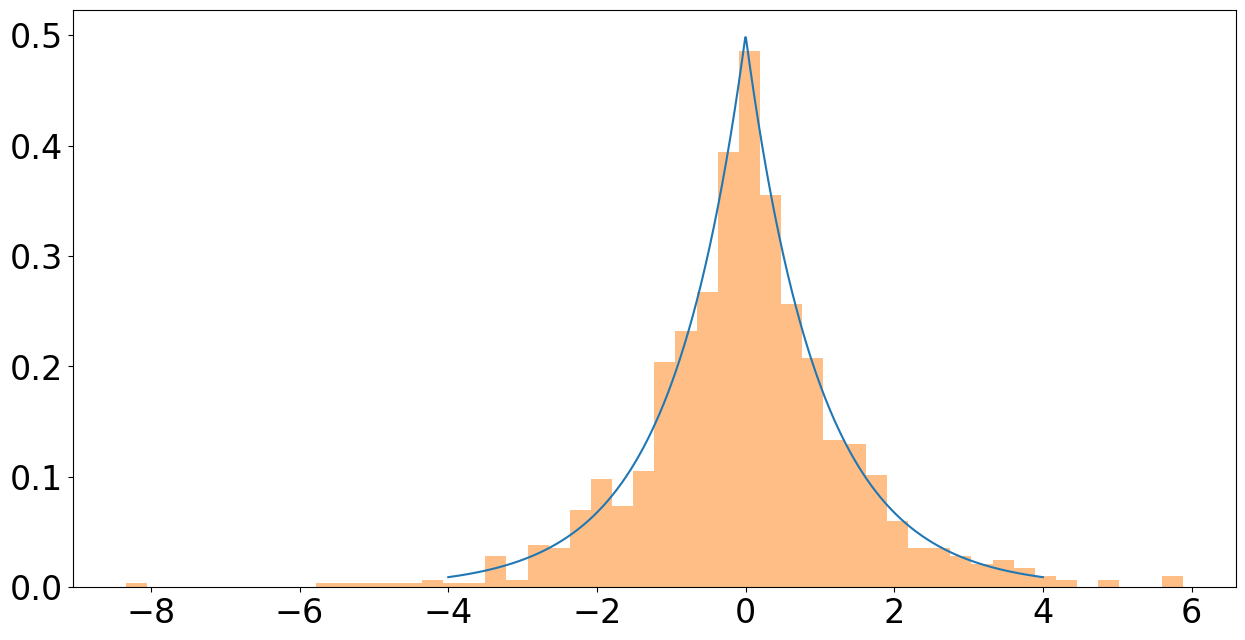

In [73]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50);

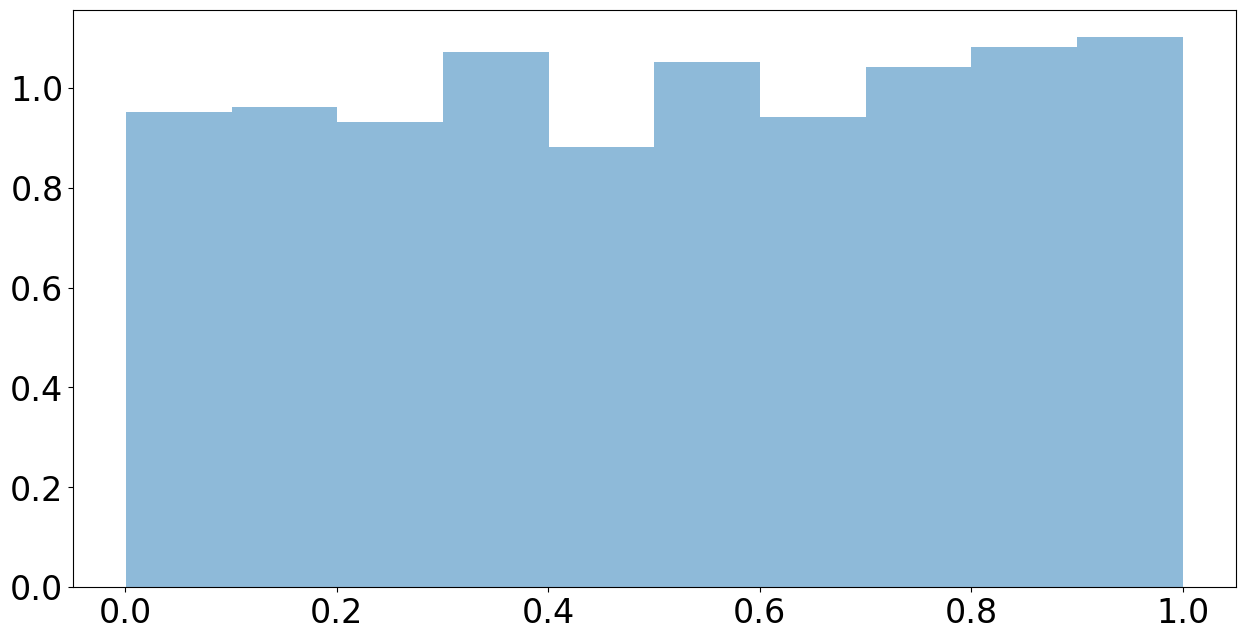

In [74]:
plt.hist(upp,alpha=0.5,density=True,bins=10);

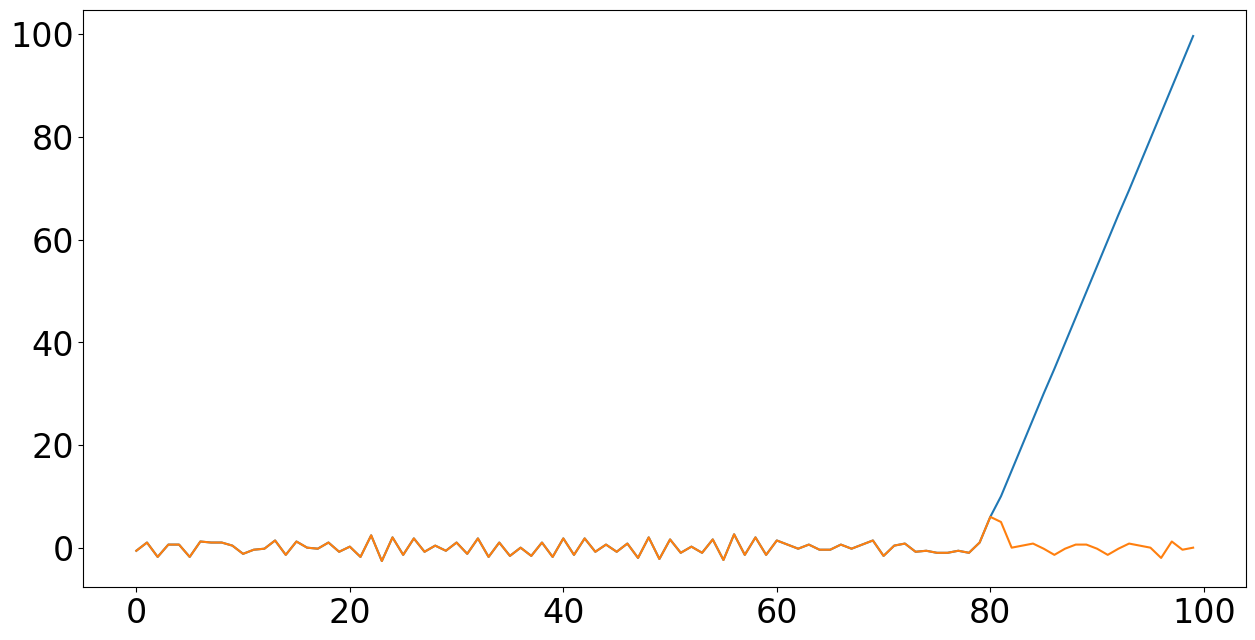

In [75]:
plt.plot(np.arange(0,steps),np.flip(xs[:,0,0]))
plt.plot(np.arange(0,steps),xps[:,0,0])

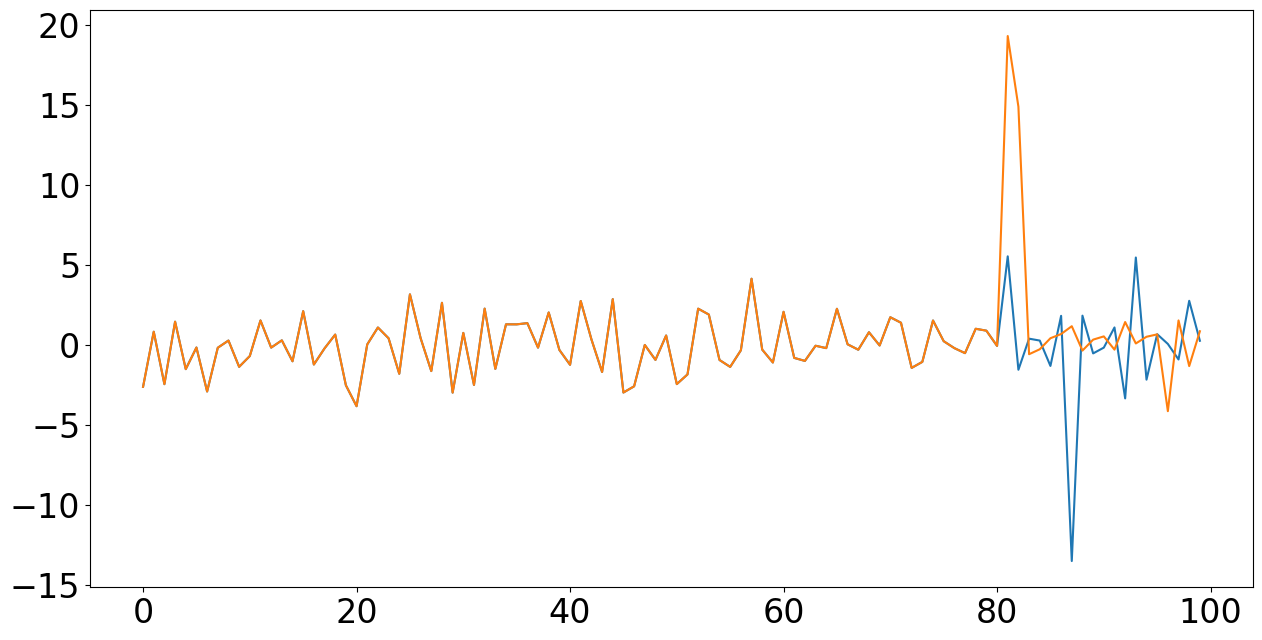

In [76]:
plt.plot(np.arange(0,steps),np.flip(rhos[:,0,0]))
plt.plot(np.arange(0,steps),rhops[:,0,0])

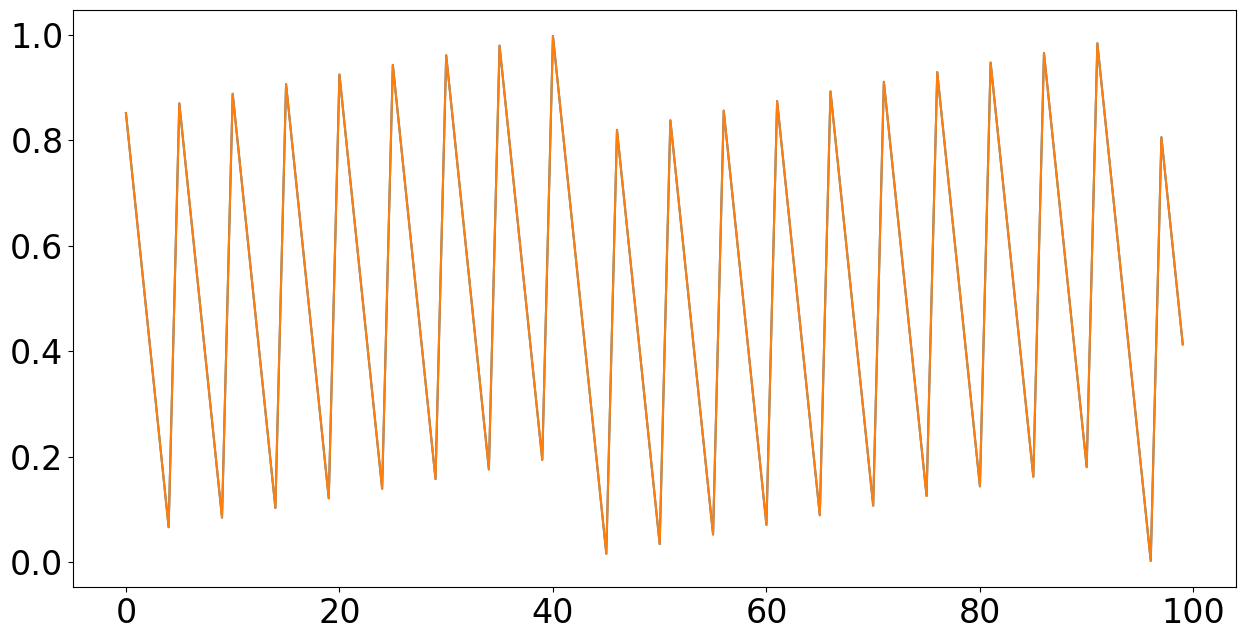

In [77]:
plt.plot(np.arange(0,steps),np.flip(us[:,0]))
plt.plot(np.arange(0,steps),ups[:,0])

In [78]:
np.flip(xs[:,0,0])

array([-5.51923010e-01,  1.04807699e+00, -1.75192301e+00,  6.48076990e-01,
        6.48076990e-01, -1.75192301e+00,  1.24807699e+00,  1.04807699e+00,
        1.04807699e+00,  4.48076990e-01, -1.15192301e+00, -3.51923010e-01,
       -1.51923010e-01,  1.44807699e+00, -1.35192301e+00,  1.24807699e+00,
        4.80769896e-02, -1.51923010e-01,  1.04807699e+00, -7.51923010e-01,
        2.48076990e-01, -1.75192301e+00,  2.44807699e+00, -2.55192301e+00,
        2.04807699e+00, -1.35192301e+00,  1.84807699e+00, -7.51923010e-01,
        4.48076990e-01, -5.51923010e-01,  1.04807699e+00, -1.15192301e+00,
        1.84807699e+00, -1.75192301e+00,  1.04807699e+00, -1.55192301e+00,
        4.80769896e-02, -1.55192301e+00,  1.04807699e+00, -1.75192301e+00,
        1.84807699e+00, -1.35192301e+00,  1.84807699e+00, -7.51923010e-01,
        6.48076990e-01, -7.51923010e-01,  8.48076990e-01, -1.95192301e+00,
        2.04807699e+00, -2.15192301e+00,  1.64807699e+00, -9.51923010e-01,
        2.48076990e-01, -

In [79]:
xps[:,0,0]

array([-0.55192301,  1.04807699, -1.75192301,  0.64807699,  0.64807699,
       -1.75192301,  1.24807699,  1.04807699,  1.04807699,  0.44807699,
       -1.15192301, -0.35192301, -0.15192301,  1.44807699, -1.35192301,
        1.24807699,  0.04807699, -0.15192301,  1.04807699, -0.75192301,
        0.24807699, -1.75192301,  2.44807699, -2.55192301,  2.04807699,
       -1.35192301,  1.84807699, -0.75192301,  0.44807699, -0.55192301,
        1.04807699, -1.15192301,  1.84807699, -1.75192301,  1.04807699,
       -1.55192301,  0.04807699, -1.55192301,  1.04807699, -1.75192301,
        1.84807699, -1.35192301,  1.84807699, -0.75192301,  0.64807699,
       -0.75192301,  0.84807699, -1.95192301,  2.04807699, -2.15192301,
        1.64807699, -0.95192301,  0.24807699, -0.95192301,  1.64807699,
       -2.35192301,  2.64807699, -1.35192301,  2.04807699, -1.35192301,
        1.44807699,  0.64807699, -0.15192301,  0.64807699, -0.35192301,
       -0.35192301,  0.64807699, -0.15192301,  0.64807699,  1.44

In [80]:
np.flip(rhos[:,0,0])

array([-2.61538448e+00,  8.29907825e-01, -2.45088666e+00,  1.45743522e+00,
       -1.51038974e+00, -1.57755294e-01, -2.91003200e+00, -1.73278579e-01,
        2.77579560e-01, -1.36660011e+00, -6.90750608e-01,  1.53267435e+00,
       -1.65979112e-01,  2.91011023e-01, -1.01930659e+00,  2.11550188e+00,
       -1.22210968e+00, -2.13628394e-01,  6.50706903e-01, -2.51876854e+00,
       -3.82799084e+00,  3.31852912e-02,  1.09355263e+00,  4.18135424e-01,
       -1.80113335e+00,  3.16585020e+00,  4.26424961e-01, -1.63261484e+00,
        2.63572839e+00, -2.97842018e+00,  7.55814048e-01, -2.50104644e+00,
        2.27170906e+00, -1.49572205e+00,  1.29144328e+00,  1.28940333e+00,
        1.36477298e+00, -1.67162708e-01,  2.03285488e+00, -3.10577318e-01,
       -1.23919180e+00,  2.75013683e+00,  3.54261475e-01, -1.68984364e+00,
        2.86449606e+00, -2.97221601e+00, -2.58419854e+00,  1.63162473e-03,
       -9.33000605e-01,  5.93541405e-01, -2.44547461e+00, -1.84118362e+00,
        2.26895774e+00,  

In [81]:
rhops[:,0,0]

array([-2.61538448e+00,  8.29907825e-01, -2.45088666e+00,  1.45743522e+00,
       -1.51038974e+00, -1.57755294e-01, -2.91003200e+00, -1.73278579e-01,
        2.77579560e-01, -1.36660011e+00, -6.90750608e-01,  1.53267435e+00,
       -1.65979112e-01,  2.91011023e-01, -1.01930659e+00,  2.11550188e+00,
       -1.22210968e+00, -2.13628394e-01,  6.50706903e-01, -2.51876854e+00,
       -3.82799084e+00,  3.31852912e-02,  1.09355263e+00,  4.18135424e-01,
       -1.80113335e+00,  3.16585020e+00,  4.26424961e-01, -1.63261484e+00,
        2.63572839e+00, -2.97842018e+00,  7.55814048e-01, -2.50104644e+00,
        2.27170906e+00, -1.49572205e+00,  1.29144328e+00,  1.28940333e+00,
        1.36477298e+00, -1.67162708e-01,  2.03285488e+00, -3.10577318e-01,
       -1.23919180e+00,  2.75013683e+00,  3.54261475e-01, -1.68984364e+00,
        2.86449606e+00, -2.97221601e+00, -2.58419854e+00,  1.63162473e-03,
       -9.33000605e-01,  5.93541405e-01, -2.44547461e+00, -1.84118362e+00,
        2.26895774e+00,  